# EDA | Problem exploration
---
---

# Imports

#### Standard library imports

In [5]:
import sys
sys.path.append("../../")
import pickle

#### Third party imports

In [6]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Local application imports

In [7]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extracting data

## 2022-2023 Dataset

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
dfx

## Query

In [ ]:
## Function parameters
db_crds = 'pc_db_prod'
sql_files_path = '../../pkg_dir/sql/'
sql_script = 'appointments.sql'
sql_params = sql_params_appointments

In [ ]:
dfx = sql_to_df(db_crds, sql_files_path, sql_script, sql_params)

In [ ]:
## Reference to simplify labels in appointment status
values_map = {
    
    'COMPLETADA': 'completed',
    'SALA_ESPERA': 'completed',
    'CONSULTA': 'completed',
    'CONFIRMADO_PAGO': 'completed',

    'NO_PRESENTO': 'no_show',
    'MENSAJE_DEJADO': 'no_show',
    'NO_CONFIRMADO': 'no_show',
    'CONFIRMADO': 'no_show',
    'LLEGA_TARDE_ESPERA': 'no_show',
    'REAGENDAR': 'no_show',
    
}

In [ ]:
## Mapping values according to reference
dfx['appointment_status_simple'] = dfx['appointment_status'].map(values_map).fillna(dfx['appointment_status'])

In [ ]:
## Formatting appointment date
dfx['appointment_date'] = pd.to_datetime(dfx['appointment_date'])

# Solving questions - no shows

---
### What was the no-show rate in 2023?

##### 
##### Using query

In [ ]:
sql_string = """
SELECT cita.citaid as appointment_id

FROM cita

WHERE citafecha >= '2000-11-03'
  AND citafecha <= '2021-01-01'

ORDER BY
    citafecha DESC

LIMIT 10

;
"""

In [ ]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "appointment_id",
    }, 
    inplace=True
)

In [ ]:
dfx['appointment_status_simple'].value_counts()

In [ ]:
dfx['appointment_status_simple'].value_counts(normalize=True)

##### 
##### Using 2022-2023 dataset

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
# mr1 = dfx['appointment_status_simplified'].isin(['unused', 'completed', 'no_show'])
mr1 = dfx['appointment_status_simplified'].isin(['completed', 'no_show'])
mr2 = dfx['appointment_start'].dt.year == 2023
mrs = mr1 & mr2

rc = ['appointment_status_simplified', 'appointment_id']

In [ ]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts()

In [ ]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts(normalize=True)

In [ ]:
#2022
31176 / (31176 + 103480)

In [ ]:
#2023
25653 / (25653 + 138654)

---
### What was the last status of the confirmed appointments?

---
### No-show rate in 2023 segmented per clinic

##### 
##### With final dataset

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'clinic',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
        'clinic',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
dfy = dfy.pivot(
    index=['appointment_date', 'clinic'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [ ]:
dfy.fillna(0, inplace=True)

In [ ]:
dfy['appts'] = dfy['completed'] + dfy['no_show']
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']

In [ ]:
dfy['ns/appt'] = dfy['no_show']/(dfy['appts'])
dfy['ns/total'] = dfy['no_show']/dfy['total']

In [ ]:
dfy

##### 
##### Original calculation

In [ ]:
## Grouping data by clinic
dfy = dfx.loc[:, ['appointment_id', 'appointment_status_simple', 'clinic']].groupby(
    [
        'clinic',
        'appointment_status_simple',
    ],
    # as_index=False
).agg(
    {
        'appointment_id': 'count'
    }
)

## Renaming aggregate column
dfy.rename(columns={'appointment_id': 'count'}, inplace=True)

In [ ]:
## Adding new column with proportions per clinic
dfy["proportion"] = dfy['count']/dfy.groupby(["clinic"])["count"].transform("sum")

In [ ]:
dfy

In [ ]:
plt = sns.barplot(
    dfy, 
    x="clinic", 
    y="count", 
    hue="appointment_status_simple", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

---
### Evolution of no shows in clinics

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mrs = mr1 #& mr2

rc = [
    'appointment_id',
    'appointment_start',
    'clinic',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='QS'),
        'clinic',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
dfy = dfy.pivot(
    index=['appointment_start', 'clinic'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [ ]:
dfy.fillna(0, inplace=True)

In [ ]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

In [ ]:
dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

In [ ]:
dfy

In [ ]:
dfy = dfy[dfy['ns_ratio'] < 0.4].copy()

In [ ]:
sns.lineplot(
    x="appointment_start", 
    y="ns_ratio",
    hue="clinic",
    data=dfy,
    markers=True
)

---
### No show rate per month

##### Overall

In [8]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [10]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mrs = mr1 #& mr2

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [11]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='m'),
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [13]:
dfy = dfy.pivot(
    index=['appointment_start'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [15]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

In [16]:
dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

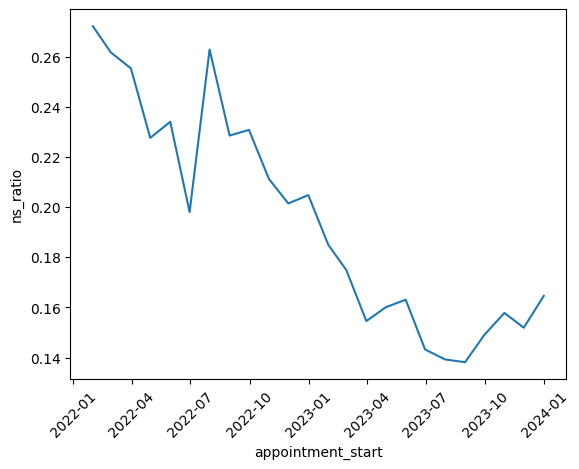

In [19]:
plt = sns.lineplot(
    dfy, 
    x="appointment_start", 
    y="ns_ratio", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

##### Overall

In [29]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [30]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [31]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['medical_specialty'].isin(specialty)
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'medical_specialty',
    'appointment_start',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [32]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='m'),
        'medical_specialty',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [33]:
dfy = dfy.pivot(
    index=['appointment_start', 'medical_specialty'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [35]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

In [36]:
dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

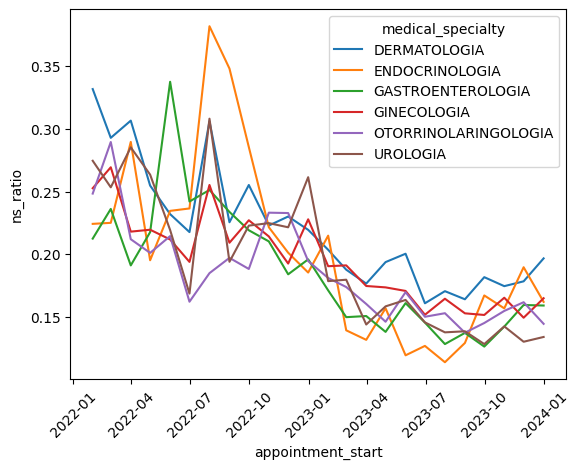

In [39]:
plt = sns.lineplot(
    dfy, 
    x="appointment_start", 
    y="ns_ratio", 
    hue="medical_specialty", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

---
### How many historic data points we have of appointments?

In [ ]:
sql_string = """
SELECT DATE_PART('year', citafecha) as appointment_year,
       COUNT(*) as entry_count

FROM cita

INNER JOIN sucursal ON cita.citasucursalid = sucursal.sucursalid
INNER JOIN citaestatus c ON cita.citaid = c.citaid AND cita.citaanio = c.citaanio

WHERE citafecha >= '2000-11-03'
  AND citafecha < '2024-01-01'
  AND c.cestatusobs ~* '\yCreado\y'
  AND citaestado IN (
                         'DISPONIBLE',
                         'NO_PRESENTO',
                         'COMPLETADA'
                        )

GROUP BY appointment_year

;"""

In [ ]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "year",
        1: "count",
    }, 
    inplace=True
)

In [ ]:
dfx

---
### Average number of appointments per speciality

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_start'].dt.year == 2023
mr3 = dfx['appointment_start'].dt.weekday < 5 ## only weekdays
# mr4 = dfx['clinic'] == 'BASILICA'
mrs = mr1 & mr2 & mr3# & mr4

rc = [
    'appointment_id',
    'appointment_start',
    'clinic',
    'doctor',
    'medical_specialty',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='d'),
        'medical_specialty',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy

In [ ]:
dfy = dfy.pivot(
    index=['appointment_start', 'medical_specialty'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [ ]:
## 
dfy.fillna(0, inplace=True)

In [ ]:
dfy['total_agenda'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']
dfy['occupation_ratio'] = 1 - dfy['unused']/dfy['total_agenda']

In [ ]:
dfy2 = dfy.groupby(
    [
        'medical_specialty',
    ]
).agg(
    {
        'completed': 'mean',
        'no_show': 'mean',
        'ns_ratio': 'mean',
        'occupation_ratio': 'mean',
        'unused': 'mean',
        # 'total_agenda': ['mean', 'sum'],
        'total_used': ['mean', 'sum'],
        'appointment_start': 'nunique',
    }
)

# dfy2.columns = [col[0] + '_$' + col[1] for col in dfy2.columns]

dfy2.sort_values(by=('total_used', 'sum'), inplace=True, ascending=False)

dfy2

---
### Average number of doctors per specialty and per location

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
clinic = ['BASILICA', 'COAPA', 'MARINA NACIONAL', 'TLALPAN', 'MONTEVIDEO']

In [ ]:
mr1 = dfx['appointment_start'].dt.weekday < 5 ## only weekdays
mr2 = dfx['medical_specialty'].isin(specialty)
mr3 = dfx['clinic'].isin(clinic)
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_start',
    'clinic',
        'medical_specialty',
    'doctor',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='d'),
        'medical_specialty',
        'clinic',
    ],
    as_index=False
).agg(
    {
        'doctor': 'nunique',
    }
)


In [ ]:
dfy = dfy.groupby(
    [
        'medical_specialty',
        'clinic',
    ],
    as_index=False
).agg(
    {
        'doctor': 'mean',
    }
)

dfy

---
### No shows per specialty in 2023

###### 
###### Old calculation

In [ ]:
## Grouping data by clinic
dfy = dfx.groupby(
    [
        'medical_specialty',
        'appointment_status_simple',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count'
    }
)

## Renaming aggregate column
dfy.rename(columns={'appointment_id': 'count'}, inplace=True)

In [ ]:
## Adding new column with proportions
dfy["proportion"] = dfy['count']/dfy.groupby(["medical_specialty"])["count"].transform("sum")

In [ ]:
dfy.loc[dfy['appointment_status_simple'] == 'no_show', :].sort_values(by='proportion', ascending=False)

In [ ]:
dfy

In [ ]:
dfy

---
### How many of the no-shows are patients that were confirmed?

In [ ]:
mr1 = dfy['appointment_status_simplified'] == 'no_show'
mrs = mr1

rc = [
    'appointment_id',
    'appointment_date',
    'meta__confirmed_$date',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['meta__confirmed_$date'] = dfy['meta__confirmed_$date'].fillna('not_confirmed')

In [ ]:
dfy['meta__confirmed_$date'] = dfy['meta__confirmed_$date'].apply(lambda x: 'confirmed' if x != 'not_confirmed' else x)

In [ ]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
        'meta__confirmed_$date',
    ]
).agg(
    'count'
)

dfy

In [ ]:
## Adding new column with proportions per clinic
dfy["proportion"] = dfy['appointment_id']/dfy.groupby(['appointment_date'])["appointment_id"].transform("sum")

In [ ]:
dfy

---
### Appointments by channel

In [ ]:
mr1 = dfx['meta__created_$user'].notnull()
mrs = mr1

rc = [
    'appointment_id',
    'appointment_date',
    'meta__created_$user',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['meta__created_$user'] = dfy['meta__created_$user'].apply(lambda x: 'online' if x == 'citas.online' else 'phone')

In [ ]:
dfy['meta__created_$user'].value_counts()

In [ ]:
dfy[dfy['meta__created_$user'].str.contains('online')]

In [ ]:
dfy['meta__created_$user'].unique()

In [ ]:
dfy[dfy['meta__created_$user'].str.contains('online')]['appointment_status_simplified'].value_counts()

In [ ]:
dfy['meta__created_$user'].info()

In [ ]:
dfx

---
### Specialties and lead time

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
appt_status = ['cancel_patient', 'completed', 'no_show']

In [ ]:
dfx['appointment_status_simplified'].unique()

In [ ]:
mr1 = (dfx['creation_to_start_hrs'] > 0) & (dfx['creation_to_start_hrs'] < 12000)
mr2 = dfx['medical_specialty'].isin(specialty)
mr3 = dfx['appointment_status_simplified'].isin(appt_status)

mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'medical_specialty',
    'creation_to_start_hrs',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
sns.boxplot(data=dfy, x="creation_to_start_hrs", y="medical_specialty")

In [ ]:
mr1 = (dfx['creation_to_start_hrs'] > 0) & (dfx['creation_to_start_hrs'] < 12000)
mr2 = dfx['medical_specialty'].isin(specialty)
mr3 = dfx['appointment_status_simplified'].isin(appt_status)

mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'medical_specialty',
    'creation_to_start_hrs',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
sns.boxplot(data=dfy, x="creation_to_start_hrs", y="medical_specialty", hue='appointment_status_simplified')

---
### How do appointments behave per time of day?

##### 
##### All appointments

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [ ]:
tr = 0.5
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [ ]:
dfy.groupby(
    [
        # 'start_time',
        'st_bins',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
)

##### 
##### Separating by status

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [ ]:
tr = 0.5
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [ ]:
dfy.groupby(
    [
        'appointment_status_simplified',
        'st_bins',
    ],
    # as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
    hue='appointment_status_simplified',
)

##### 
##### Focusing on clinic

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mr4 = dfx['clinic'] == 'BASILICA' 
mrs = mr1 & mr2 & mr3 & mr4

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [ ]:
tr = 1
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [ ]:
dfy.groupby(
    [
        'st_bins',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
)

In [ ]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
    hue='appointment_status_simplified',
    # title='Clinic: Basilica',
)

##### 
##### Focusing on clinic and specialty
- `Any specialty` in `Any clinic`

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
dfx['appointment_start_hr'] = dfx['appointment_start'].dt.hour

In [ ]:
# specialty = 'DERMATOLOGIA'
# specialty = 'GINECOLOGIA'
# specialty = 'OTORRINOLARINGOLOGIA'
specialty = 'UROLOGIA'

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'no_show', 
        'completed', 
        'unused', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
# mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
# mr4 = dfx['clinic'] == 'BASILICA' 
# mr5 = dfx['medical_specialty'] == specialty
mr5 = dfx['medical_specialty'].isin(specialty)

# mrs = mr1 & mr2 & mr3 & mr4 & mr5
# mrs = mr1 & mr2 & mr4 & mr5
# mrs = mr1 & mr4 & mr5
mrs = mr1 & mr5

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_start_hr',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'appointment_start_hr',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

# dfy

In [ ]:
dfy = dfy.pivot(
    index=['appointment_start_hr'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

dfy.fillna(0, inplace=True)

In [ ]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

In [ ]:
mr1 = dfy['ns_ratio'].notnull()
mr2 = dfy['total_used'] > 100
mrs = mr1 & mr2

dfy = dfy.loc[mrs, :].copy()

In [ ]:
sns.barplot(
    data=dfy, 
    x="appointment_start_hr",
    y="ns_ratio",
)

##### 
##### Focusing on clinic and specialty
- `Gynecology` in Basilica

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
dfx['appointment_start_hr'] = dfx['appointment_start'].dt.hour

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'no_show', 
        'completed', 
        'unused', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
# mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mr4 = dfx['clinic'] == 'BASILICA' 
mr5 = dfx['medical_specialty'] == 'GINECOLOGIA'

# mrs = mr1 & mr2 & mr3 & mr4 & mr5
# mrs = mr1 & mr2 & mr4 & mr5
mrs = mr1 & mr4 & mr5

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_start_hr',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'appointment_start_hr',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy

In [ ]:
dfy = dfy.pivot(
    index=['appointment_start_hr'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

dfy.fillna(0, inplace=True)

In [ ]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

In [ ]:
sns.barplot(
    data=dfy, 
    x="appointment_start_hr",
    y="ns_ratio",
)

---
### How do appointments behave per weekday?

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
# specialty = 'DERMATOLOGIA'#, 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
specialty = 'GINECOLOGIA'#, 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
# specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
# mr2 = dfx['appointment_start'].dt.year == 2023 ## only weekdays
# mr2 = dfx['medical_specialty'].isin(specialty)
mr2 = dfx['medical_specialty'] == specialty
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'appointment_weekday',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'appointment_weekday',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
dfy = dfy.pivot(
    index=['appointment_weekday'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [ ]:
dfy['total_agenda'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']
dfy['occupation_ratio'] = 1 - dfy['unused']/dfy['total_agenda']

In [ ]:
sns.barplot(
    data=dfy, 
    x="appointment_weekday",
    y="ns_ratio",
)

---
### What are the most popular times of day when appointments are scheduled

---
### With how much time in advance are appointments confirmed?

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
mr1 = dfx['confirm_to_start_hrs'].notnull()
mr2 = dfx['confirm_to_start_hrs'] <= 24*7
mr3 = dfx['confirm_to_start_hrs'] >= 0
mr4 = dfx['appointment_start'].dt.year == 2023
mrs = mr1 & mr2 & mr3 & mr4

rc = [
    'appointment_id',
    'appointment_start',
    'confirm_to_start_hrs',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['confirm_to_start_hrs'].plot(kind='hist', rwidth=0.8, bins=100)

---
### Confirmation time and cancellations
- When can we neglect cancellations as a label?

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
mr1 = dfx['confirm_to_start_hrs'].notnull()
mr2 = dfx['confirm_to_start_hrs'] <= 24
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'appointment_start',
    'confirm_to_start_hrs',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['confirm_to_start_hrs'].describe()

In [ ]:
dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='Y'),
        'appointment_status_simplified',
    ],
).agg(
    {
        'appointment_id': 'count',
    }
)

---
### What's the outcome of appointments that have a confirmation request message?

---
### Patient recurrance

##### Per speciality

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [ ]:
mr1 = dfx['recurring_patient'].notnull()
mr2 = dfx['medical_specialty'].isin(specialty)

mrs = mr1 & mr2

rc = [
    'appointment_id',
    'medical_specialty',
    'recurring_patient',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'medical_specialty',
        'recurring_patient',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy['proportion'] = dfy['appointment_id']/dfy.groupby(['medical_specialty'])['appointment_id'].transform('sum')

# dfy

In [ ]:
# Medical specialties and their proportions of first-time and recurrent patients
specialties = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
first_time_proportions = dfy.loc[dfy['recurring_patient'] == 'first', 'proportion']
recurrent_proportions = dfy.loc[dfy['recurring_patient'] == 'recurrent', 'proportion']

# Positions of each medical specialty
ind = np.arange(len(specialties))

# Width of the bars
width = 0.5

# Plotting the bars
fig, ax = plt.subplots()
bars_first_time = ax.bar(ind, first_time_proportions, width, label='First-time')
bars_recurrent = ax.bar(ind, recurrent_proportions, width, bottom=first_time_proportions, label='Recurrent')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Medical Specialty')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of First-time and Recurrent Patients by Medical Specialty')
ax.set_xticks(ind)
ax.set_xticklabels(specialties, rotation=45, ha="right")
ax.legend()

# Adding a legend
ax.legend()

plt.show()


---
### Patient recurrance affects no-shows?

##### V1 - no-shows vs completed

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
mr1 = dfx['appointment_status_simplified'] != 'cancel'
mrs = mr1

rc = [
    'appointment_id',
    'recurring_patient',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mr1, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        # pd.Grouper(key='appointment_start', freq='Y'),
        'recurring_patient',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy["proportion"] = dfy['appointment_id']/dfy.groupby(['recurring_patient'])["appointment_id"].transform("sum")
dfy

##### V5 - failed vs completed

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v5.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
rc = [
    'appointment_id',
    'recurring_patient',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[:, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        # pd.Grouper(key='appointment_start', freq='Y'),
        'recurring_patient',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy["proportion"] = dfy['appointment_id']/dfy.groupby(['recurring_patient'])["appointment_id"].transform("sum")
dfy

---
### Age distribution

##### 
##### Focusing on clinic and specialty
- `Any specialty` in `Any clinic`

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [ ]:
mr1 = dfx['medical_specialty'].isin(specialty)
mr2 = dfx['patient_age'].notnull()

mrs = mr1 & mr2

rc = [
    'appointment_id',
    'medical_specialty',
    'patient_age',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
sns.boxplot(data=dfy, x="patient_age", y="medical_specialty")

---
### How many of the cancellations by chatbot?

---
### Sex distribution

In [42]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [43]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [44]:
mr1 = dfx['patient_sex'].notnull()
mr2 = dfx['medical_specialty'].isin(specialty)

mrs = mr1 & mr2

rc = [
    'appointment_id',
    'medical_specialty',
    'patient_sex',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'medical_specialty',
        'patient_sex',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy['proportion'] = dfy['appointment_id']/dfy.groupby(['medical_specialty'])['appointment_id'].transform('sum')

# dfy

In [ ]:
# Medical specialties and their proportions of first-time and recurrent patients
# specialties = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
specialties = dfy['medical_specialty'].unique()
female_prop = dfy.loc[dfy['patient_sex'] == 'F', 'proportion']
male_prop = dfy.loc[dfy['patient_sex'] == 'M', 'proportion']

# Positions of each medical specialty
ind = np.arange(len(specialties))

# Width of the bars
width = 0.5

# Plotting the bars
fig, ax = plt.subplots()
bars_first_time = ax.bar(ind, female_prop, width, label='Female')
bars_recurrent = ax.bar(ind, male_prop, width, bottom=female_prop, label='Male')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Medical Specialty')
ax.set_ylabel('Proportion')
ax.set_title('Sex ditribution')
ax.set_xticks(ind)
ax.set_xticklabels(specialties, rotation=45, ha="right")
ax.legend()

# Adding a legend
ax.legend()

plt.show()


---
### Distribution of no shows throughout the day

##### Dermatology

In [84]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [85]:
dfx['appointment_start_hr'] = dfx['appointment_start'].dt.hour
# dfx['appointment_start_day'] = dfx['appointment_start'].dt.date

In [86]:
mr1 = dfx['medical_specialty'] == 'DERMATOLOGIA'
mr2 = dfx['clinic'] == 'BASILICA'
mr3 = dfx['appointment_status_simplified'] == 'no_show'

mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_start_hr',
]


dfy = dfx.loc[mrs, rc].copy()

In [87]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='d'),
        'appointment_start_hr',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)


In [89]:
dfy = dfy.groupby(
    [
        'appointment_start_hr',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'mean',
    }
)


---
### How many days of the year went by with a no-show

In [102]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [103]:
mr1 = dfx['medical_specialty'] == 'DERMATOLOGIA'
mr2 = dfx['clinic'] == 'BASILICA'
mr3 = dfx['appointment_status_simplified'].isin(['completed', 'no_show', 'unused'])

mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [104]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='d'),
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)


In [105]:
dfy = dfy.pivot(
    index=['appointment_start'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

dfy.fillna(0, inplace=True)

In [109]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_bool'] = dfy['total'].apply(lambda x: 1 if x > 0 else 0)
dfy['no_show_bool'] = dfy['no_show'].apply(lambda x: 1 if x > 0 else 0)

In [111]:
dfy['no_show_bool'].value_counts(normalize=True)

no_show_bool
1    0.990307
0    0.009693
Name: proportion, dtype: float64

In [112]:
dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='Y'),
    ],
    as_index=False
).agg(
    {
        'total_bool': 'sum',
        'no_show_bool': 'sum',
    }
)


,appointment_start,total_bool,no_show_bool
0,2022-12-31,304,301
1,2023-12-31,315,312


---
### xxx

---
---
# Solving questions - cancelations

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

---
### What is the cancellation rate
- How many cancellations per employee are there in a day per number of used spots (no-show & completed)

In [ ]:
# mr1 = dfx['appointment_status_simplified'].isin(['unused', 'completed', 'no_show'])
mr1 = dfx['appointment_status_simplified'].isin(['completed', 'no_show'])
mr2 = dfx['appointment_start'].dt.year == 2023
mrs = mr1 & mr2

rc = ['appointment_status_simplified', 'appointment_id']

In [ ]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts()

In [ ]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts(normalize=True)

In [ ]:
#2022
31176 / (31176 + 103480)

In [ ]:
#2023
25653 / (25653 + 138654)

In [ ]:
dfx

---
---
# Notes

### Duplicated values

In [ ]:
dfx.loc[dfx[['appointment_id']].duplicated(keep=False), :].sort_values('appointment_id')

### Executing custom query

In [ ]:
sql_string = """
SELECT cita.citaid as appointment_id

FROM cita

WHERE citafecha >= '2000-11-03'
  AND citafecha <= '2021-01-01'

ORDER BY
    citafecha DESC

LIMIT 10

;
"""

In [ ]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "appointment_id",
    }, 
    inplace=True
)

### Number of total appointments

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'completed', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mrs = mr1# & mr2

rc = [
    'appointment_id',
    'appointment_date',
    'clinic',
    'doctor',
    'medical_specialty',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy2 = dfy.groupby(
    [
        # pd.Grouper(key='appointment_date', freq='W'),
        'appointment_date',
        'clinic',
    ],
    as_index=False
).agg(
    {
        'doctor': 'nunique'
    }
)

dfy2[-25:]

In [ ]:
dfy2.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
    ]
).agg(
    {
        'appointment_status_simplified': 'mean'
    }
)

In [ ]:
dfy = dfy.groupby(
    [
        'appointment_date',
        'medical_specialty',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy

### xxx

---

---